## Overview

This is an executable notebook version of [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) 

## Imports

In [18]:
from easyfinetune.datasets import dogs_vs_cats
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import Model
from keras import optimizers
import numpy as np
import os

## Get the data

In [2]:
dogs_vs_cats_data = dogs_vs_cats.download(extract=True)
train_data_dir = os.path.join(dogs_vs_cats_data, "train")
validation_data_dir = os.path.join(dogs_vs_cats_data, "valid")

## Train fully connected layer (aka "bottleneck features") to 90% accuracy

### Overview

Using the bottleneck features of a pre-trained network: 90% accuracy in a minute
A more refined approach would be to leverage a network pre-trained on a large dataset. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

We will use the VGG16 architecture, pre-trained on the ImageNet dataset --a model previously featured on this blog. Because the ImageNet dataset contains several "cat" classes (persian cat, siamese cat...) and many "dog" classes among its total of 1000 classes, this model will already have learned features that are relevant to our classification problem. In fact, it is possible that merely recording the softmax predictions of the model over our data rather than the bottleneck features would be enough to solve our dogs vs. cats classification problem extremely well. However, the method we present here is more likely to generalize well to a broader range of problems, including problems featuring classes absent from ImageNet.

Here's what the VGG16 architecture looks like:

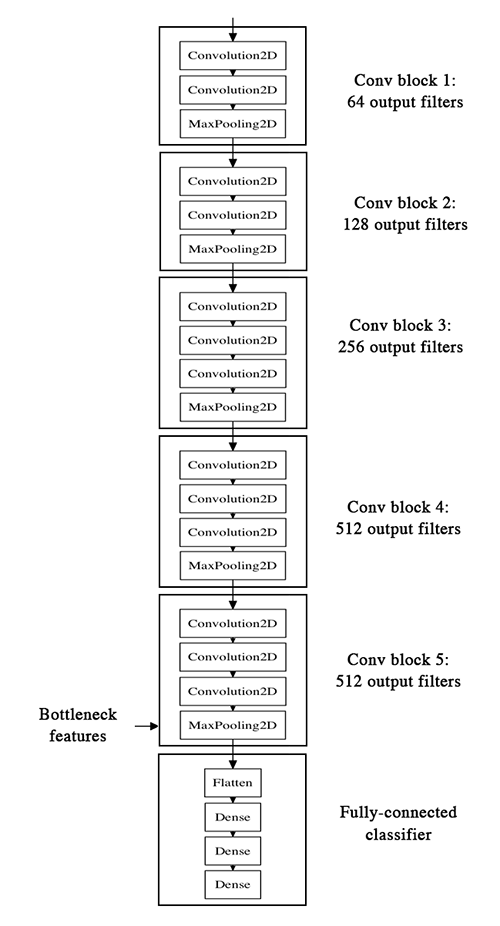

Our strategy will be as follow: we will only instantiate the convolutional part of the model, everything up to the fully-connected layers. We will then run this model on our training and validation data once, recording the output (the "bottleneck features" from th VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays. Then we will train a small fully-connected model on top of the stored features.

The reason why we are storing the features offline rather than adding our fully-connected model directly on top of a frozen convolutional base and running the whole thing, is computational effiency. Running VGG16 is expensive, especially if you're working on CPU, and we want to only do it once. Note that this prevents us from using data augmentation.

### Set parameters

In [3]:

# epochs = 50
epochs = 10
batch_size = 10

img_width, img_height = dogs_vs_cats.img_width, dogs_vs_cats.img_height
num_train_samples = dogs_vs_cats.num_train_samples
num_validation_samples = dogs_vs_cats.num_validation_samples


###  Prepare pre-trained model

In [4]:
# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### Generate bottleneck features

Create a function that does a *single* forward pass through the convolutional blocks of the network with the full dataset and save the outputs.

In [5]:
def generate_bottlebeck_features(model):
    
    datagen = ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    bottleneck_features_train = model.predict_generator(
        generator, 
        num_train_samples // batch_size, 
        verbose=1,
    )
    
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    bottleneck_features_validation = model.predict_generator(
        generator, 
        num_validation_samples // batch_size, 
        verbose=1,
    )
        
    return (bottleneck_features_train, bottleneck_features_validation)

Run this model on our training and validation data once, recording the output 
(the "bottleneck features" from th VGG16 model: the last activation maps before the fully-connected layers) 
in two numpy arrays


In [6]:
bottleneck_features_train, bottleneck_features_validation = generate_bottlebeck_features(model)

Found 23000 images belonging to 2 classes.
2300/2300 [==============================] - 114s 49ms/step
Found 2000 images belonging to 2 classes.
200/200 [==============================] - 12s 62ms/step


### Train fully connected layer (aka "Top-Model")

Train a small fully-connected model on top of the bottleneck features generated above.

In [7]:
def train_top_model(bottleneck_features_train, bottleneck_features_validation):
    
    train_data = bottleneck_features_train
    train_labels = np.array([0] * (num_train_samples // 2) + [1] * (num_train_samples // 2))

    validation_data = bottleneck_features_validation
    validation_labels = np.array([0] * (num_validation_samples // 2) + [1] * (num_validation_samples // 2))

    top_model = Sequential()
    top_model.add(Flatten(input_shape=train_data.shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    top_model.compile(
        optimizer='rmsprop',          
        loss='binary_crossentropy', 
        metrics=['accuracy'],
    )

    top_model.fit(train_data, 
              train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    
    return top_model

In [8]:
top_model = train_top_model(bottleneck_features_train, bottleneck_features_validation)

Train on 23000 samples, validate on 2000 samples
Epoch 1/10
23000/23000 [==============================] - 11s 499us/step - loss: 0.3804 - acc: 0.8582 - val_loss: 0.2675 - val_acc: 0.8870
Epoch 2/10
23000/23000 [==============================] - 11s 479us/step - loss: 0.3038 - acc: 0.8873 - val_loss: 0.2597 - val_acc: 0.9045
Epoch 3/10
23000/23000 [==============================] - 12s 506us/step - loss: 0.2744 - acc: 0.8999 - val_loss: 0.3595 - val_acc: 0.8970
Epoch 4/10
23000/23000 [==============================] - 11s 497us/step - loss: 0.2656 - acc: 0.9042 - val_loss: 0.3098 - val_acc: 0.8915
Epoch 5/10
23000/23000 [==============================] - 11s 497us/step - loss: 0.2582 - acc: 0.9057 - val_loss: 0.2810 - val_acc: 0.9025
Epoch 6/10
23000/23000 [==============================] - 12s 506us/step - loss: 0.2557 - acc: 0.9109 - val_loss: 0.3416 - val_acc: 0.8905
Epoch 7/10
23000/23000 [==============================] - 12s 537us/step - loss: 0.2542 - acc: 0.9115 - val_loss: 0.2

## Fine-tuning 

To further improve our previous result, we can try to "fine-tune" the last convolutional block of the VGG16 model alongside the top-level classifier. Fine-tuning consist in starting from a trained network, then re-training it on a new dataset using very small weight updates. In our case, this can be done in 3 steps:

1. Instantiate the convolutional base of VGG16 and load its weights
1. Add our previously defined fully-connected model on top, and load its weights
1. Freeze the layers of the VGG16 model up to the last convolutional block

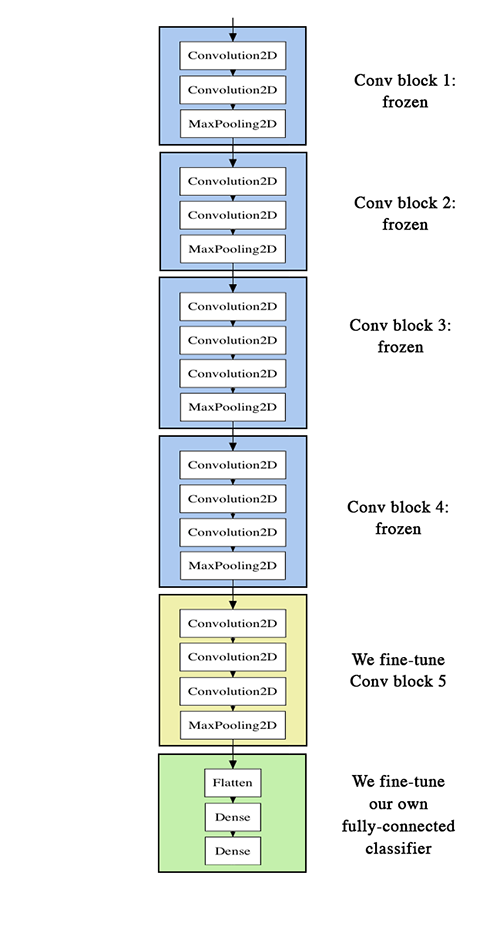

Note that:

* In order to perform fine-tuning, all layers should start with properly trained weights: for instance you should not slap a randomly initialized fully-connected network on top of a pre-trained convolutional base. This is because the large gradient updates triggered by the randomly initialized weights would wreck the learned weights in the convolutional base. In our case this is why we first train the top-level classifier, and only then start fine-tuning convolutional weights alongside it.
* We choose to only fine-tune the last convolutional block rather than the entire network in order to prevent overfitting, since the entire network would have a very large entropic capacity and thus a strong tendency to overfit. The features learned by low-level convolutional blocks are more general, less abstract than those found higher-up, so it is sensible to keep the first few blocks fixed (more general features) and only fine-tune the last one (more specialized features).
* Fine-tuning should be done with a very slow learning rate, and typically with the SGD optimizer rather than an adaptative learning rate optimizer such as RMSProp. This is to make sure that the magnitude of the updates stays very small, so as not to wreck the previously learned features.



### Set additional params

In [22]:
learning_rate = 1e-4
momentum = 0.9

# this is the number of layers that contains the first 4 (of 5 total) convblocks.
# this is special because these are the layers that we will freeze, whereas convblock 5
# will be fine-tuned.
num_first_4_convblock_layers = 15 

batch_size = 64
epochs = 25


### Instantiate base model and freeze first four conv blocks

In [28]:
base_model = applications.VGG16(
    weights='imagenet', 
    input_shape=(img_width, img_height, 3), 
    include_top=False
)

# Freeze first four conv blocks
for layer in base_model.layers[:num_first_4_convblock_layers]:
    layer.trainable = False  # aka "freeze" this layer

### Combine base model with previously trained top model

In [29]:
# add the model on top of the convolutional base
model = Model(
    input= base_model.input, 
    output=top_model(base_model.output)
)

/home/tleyden/Development/easy-fine-tune/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  after removing the cwd from sys.path.


### Compile model

In [30]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=learning_rate, momentum=momentum),
              metrics=['accuracy'])

### Connect model to input generators

In [31]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### Train model

In [32]:
model.fit_generator(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=num_validation_samples // batch_size)

Epoch 1/25
359/359 [==============================] - 167s 466ms/step - loss: 0.2429 - acc: 0.9061 - val_loss: 0.1905 - val_acc: 0.9350
Epoch 2/25
359/359 [==============================] - 154s 430ms/step - loss: 0.1974 - acc: 0.9237 - val_loss: 0.1723 - val_acc: 0.9427
Epoch 3/25
359/359 [==============================] - 158s 441ms/step - loss: 0.1778 - acc: 0.9301 - val_loss: 0.1533 - val_acc: 0.9458
Epoch 4/25
359/359 [==============================] - 156s 435ms/step - loss: 0.1616 - acc: 0.9352 - val_loss: 0.1583 - val_acc: 0.9375
Epoch 5/25
359/359 [==============================] - 157s 436ms/step - loss: 0.1493 - acc: 0.9406 - val_loss: 0.1541 - val_acc: 0.9447
Epoch 6/25
359/359 [==============================] - 152s 424ms/step - loss: 0.1436 - acc: 0.9430 - val_loss: 0.1300 - val_acc: 0.9525
Epoch 7/25
359/359 [==============================] - 157s 437ms/step - loss: 0.1292 - acc: 0.9483 - val_loss: 0.1463 - val_acc: 0.9483
Epoch 8/25
359/359 [============================